## ICDAR 2003 exploration

In [1]:
import os
from os import listdir
from os.path import isfile, join
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import numpy as np
from xml.etree import cElementTree as ElementTree

%matplotlib inline

In [2]:
# https://stackoverflow.com/questions/2148119/how-to-convert-an-xml-string-to-a-dictionary
class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

### Load data

In [3]:
imgs_dir = r"../../icdar2003/SceneTrialTest"
labels_file = r"../../icdar2003/SceneTrialTest/words.xml"

In [4]:
tree = ElementTree.parse(labels_file)
root = tree.getroot()

In [5]:
labels = {}
for i, image in enumerate(root.getchildren()):
    labels[i] = XmlDictConfig(image)

<ipython-input-5-63a08a02e306>:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  for i, image in enumerate(root.getchildren()):


In [6]:
images_files = [label['imageName'] for label in labels.values()]

### Plot random images

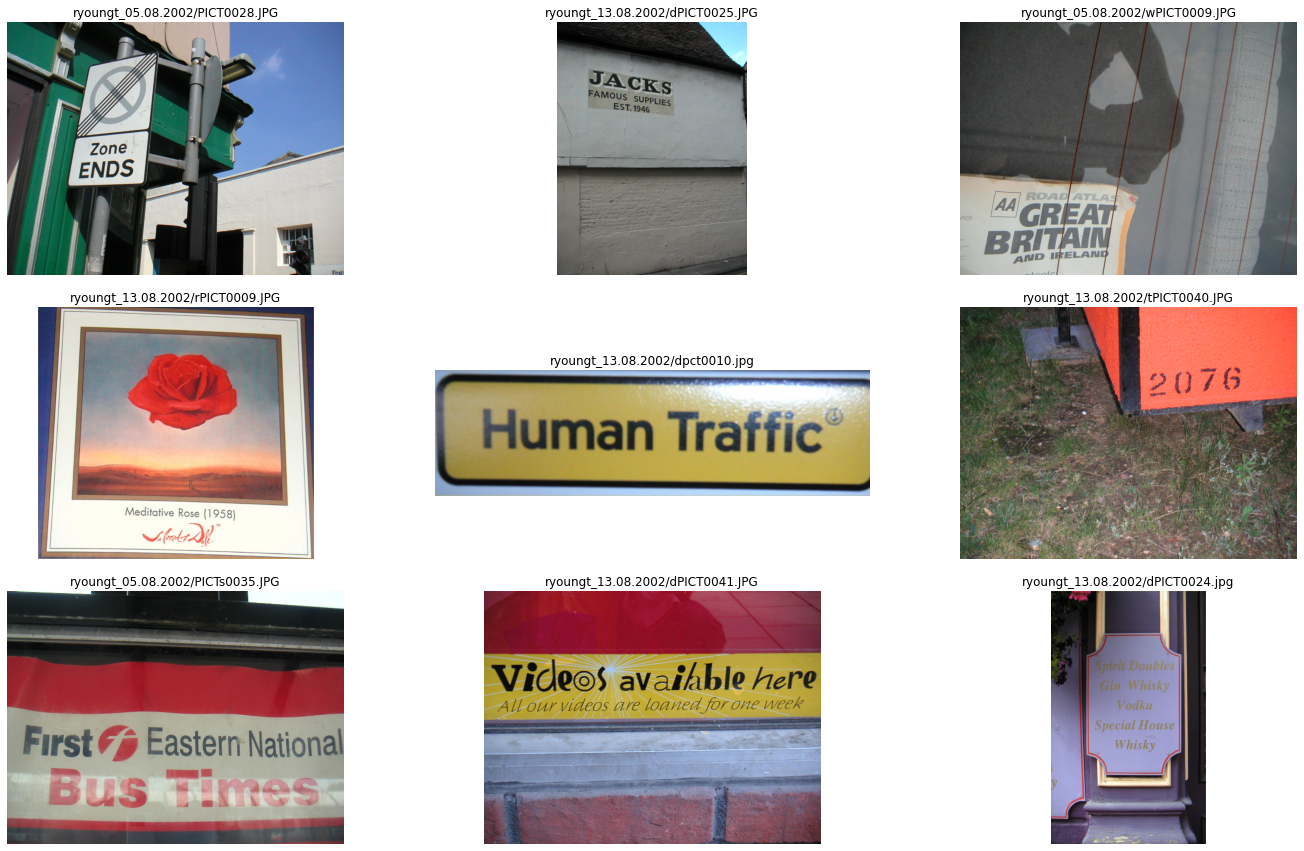

In [7]:
images_to_plot = random.sample(images_files, 9)

fig, axs = plt.subplots(3, 3, figsize=(20, 12))
plt.tight_layout()
axs = axs.flatten()
for img_name, ax in zip(images_to_plot, axs):
    
    img = cv2.imread(os.path.join(imgs_dir, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis('off')

plt.show()

### Plot image with annotations

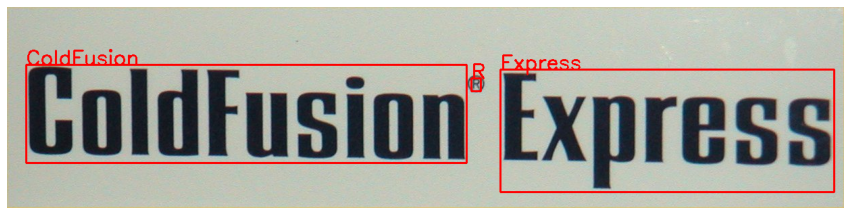

In [8]:
image_number = 121

# Transofrm bounding box annotations
annots = []
annotations = labels[image_number]['taggedRectangles']['taggedRectangle']
if isinstance(annotations, list):
    for annot in annotations:
        annot_dict = {}
        annot_dict['label'] = annot['tag']
        annot_dict['point_1'] = (int(float(annot['x'])), int(float(annot['y'])))
        annot_dict['point_2'] = (int(float(annot['x'])) + int(float(annot['width'])), int(float(annot['y'])) + int(float(annot['height'])))

        annots.append(annot_dict)
else:
    annot = annotations
    annot_dict = {}
    annot_dict['label'] = annot['tag']
    annot_dict['point_1'] = (int(float(annot['x'])), int(float(annot['y'])))    
    annot_dict['point_2'] = (int(float(annot['x'])) + int(float(annot['width'])), int(float(annot['y'])) + int(float(annot['height'])))

    annots.append(annot_dict)

# # Plot image with annotations
fig, ax = plt.subplots( figsize=(15, 15))
img = cv2.imread(os.path.join(imgs_dir, labels[image_number]['imageName']))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for text in annots:
#     if text['label'] != "###":
#         color = (0, 255, 0)
#     else:
    color = (255, 0, 0)
    cv2.rectangle(img, text['point_1'], text['point_2'] ,color, 2)
    cv2.putText(img, text['label'], text['point_1'], cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
ax.axis('off')
ax.imshow(img);

In [9]:
labels[image_number]['imageName']

'ryoungt_13.08.2002/dpct0016.jpg'

### Calculate dataset statistics

In [10]:
dataset_stats = {}

for index, label in labels.items():
    key = label['imageName']
    annotations = label['taggedRectangles']['taggedRectangle']
    dataset_stats[key] = {}
    dataset_stats[key]['annots_number'] = len(annotations) if isinstance(annotations, list) else 1
    
    if isinstance(annotations, list):
        for i, annot in enumerate(annotations):
            dataset_stats[key][i] = {}
            dataset_stats[key][i]['text'] = str(annot['tag'])
            dataset_stats[key][i]['text_len'] = len(str(annot['tag']))

            dataset_stats[key][i]['width'] = int(float(annot['width']))
            dataset_stats[key][i]['hight'] = int(float(annot['height']))
    else:
        dataset_stats[key][0] = {}
        dataset_stats[key][0]['text'] = str(annotations['tag'])
        dataset_stats[key][0]['text_len'] = len(str(annotations['tag']))

        dataset_stats[key][0]['width'] = int(float(annotations['width']))
        dataset_stats[key][0]['hight'] = int(float(annotations['height']))

In [11]:
dataset_stats[labels[image_number]['imageName']]

{'annots_number': 3,
 0: {'text': 'ColdFusion', 'text_len': 10, 'width': 652, 'hight': 145},
 1: {'text': 'R', 'text_len': 1, 'width': 14, 'hight': 19},
 2: {'text': 'Express', 'text_len': 7, 'width': 494, 'hight': 181}}

### Annotations count distribution

In [12]:
instance_without_annotation = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict) and stats['text'] == ""]
instances_all = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict)]
print(f"There are {len(instances_all)} text instances in total.")
print(f"{len(instance_without_annotation)} of them don't have annotation.")

There are 1107 text instances in total.
0 of them don't have annotation.


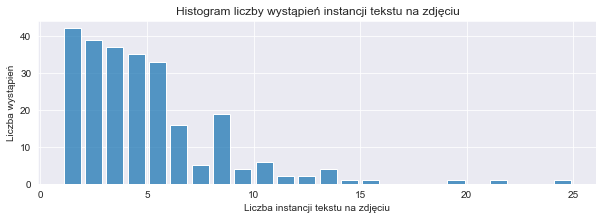

In [21]:
fig, ax = plt.subplots( figsize=(10, 3))

annotation_count = [stats['annots_number'] for stats in dataset_stats.values()]
sns.histplot(annotation_count, ax=ax, binwidth=1, shrink=.8)
# ax.hist(annotation_count, bins=100);
ax.set_xlabel("Liczba instancji tekstu na zdjęciu")
ax.set_ylabel("Liczba wystąpień")
ax.set_title("Histogram liczby wystąpień instancji tekstu na zdjęciu")
# ax.set_xticks(np.arange(0, 100, 10))
# ax.set_yticks(np.arange(0, 50, 5))
ax.grid()

### Text instances length distribution

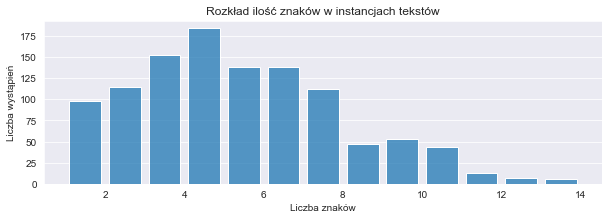

In [20]:
fig, ax = plt.subplots( figsize=(10, 3))

text_length = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
               if isinstance(stats, dict) and stats['text'] != ""]

sns.histplot(text_length, ax=ax, binwidth=1, shrink=.8)

ax.set_xlabel("Liczba znaków")
ax.set_ylabel("Liczba wystąpień")
ax.set_title("Rozkład ilość znaków w instancjach tekstów")
# ax.set_xticks(np.arange(0, 22, 1))
# ax.set_yticks(np.arange(0, 600, 50))
ax.grid(axis='y');

### Text instances width and hight

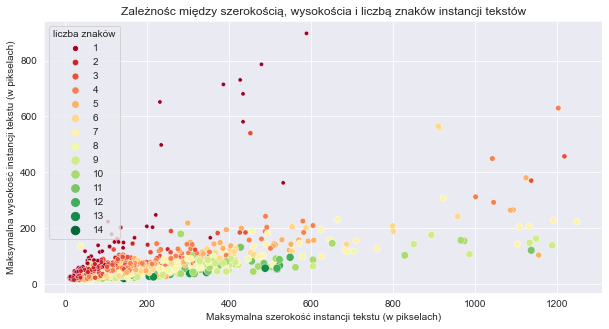

In [19]:
sns.set_style('dark')
fig, ax = plt.subplots( figsize=(10, 5))

text_length = []
text_width = []
text_hight = []

for image in dataset_stats.values():
    for stats in image.values():
        if isinstance(stats, dict):
            text_length.append(stats['text_len'])
            text_width.append(stats['width'])
            text_hight.append(stats['hight'])

df = pd.DataFrame.from_dict({
    'szerokosc': text_width,
    'wysokosc': text_hight,
    'liczba znaków': text_length,
})

sns.scatterplot(x='szerokosc', y='wysokosc', hue='liczba znaków', size='liczba znaków',data=df, palette="RdYlGn", legend='full')

ax.set_xlabel("Maksymalna szerokość instancji tekstu (w pikselach)")
ax.set_ylabel("Maksymalna wysokość instancji tekstu (w pikselach)")

ax.set_title("Zależnośc między szerokością, wysokościa i liczbą znaków instancji tekstów")
ax.grid();


In [16]:
# Save basic ICDAR2015 stats
df.to_csv("ICDAR_2003_stats.csv", index=False)